Desarollo de Modelo para Aprendizaje Superficial

In [1]:
#Importacion de librerias
# train_traffic_features_full.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


In [2]:
# ==============================
# Cargar dataset
# ==============================
df = pd.read_csv('Dataset/dataset_all1.csv')  # Ajusta el path si es necesario
print(df.head())

                                      flow_id  packets    bytes    duration  \
0  210.196.16.152:2103-152.185.184.31:2103-17     45.0   6480.0  220.210560   
1       61.139.26.122:60678-61.139.2.69:53-17     33.0   2988.0  296.189484   
2       61.139.2.69:53-61.139.26.122:60678-17     33.0   5934.0  296.190030   
3     61.139.26.122:44006-47.94.114.72:1443-6     29.0   3799.0   16.317012   
4     47.94.114.72:1443-61.139.26.122:44006-6     32.0  33838.0   16.245598   

   avg_pkt_size  syn_count  ack_count  fin_count  rst_count class  
0    144.000000        0.0        0.0        0.0        0.0  game  
1     90.545455        0.0        0.0        0.0        0.0  game  
2    179.818182        0.0        0.0        0.0        0.0  game  
3    131.000000        1.0       28.0        0.0        0.0  game  
4   1057.437500        1.0       32.0        1.0        0.0  game  


In [3]:
# ==============================
# Preparar features y etiquetas
# ==============================
X = df.drop(columns=['flow_id','class'])
y = df['class']
# Codificar etiquetas

le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Clases codificadas:", le.classes_)


Clases codificadas: ['game' 'instant-message' 'mail' 'network-storage' 'video' 'web-browsing']


In [4]:

# ==============================
# División Train/Test/Validation
# ==============================
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)
# Aproximadamente 60% train, 20% test, 20% validation

# ==============================
# GridSearchCV para RandomForest
# ==============================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

clf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Mejores hiperparámetros encontrados: {grid.best_params_}")

# ==============================


Mejores hiperparámetros encontrados: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}



=== Reporte de clasificación en VALIDATION ===
                 precision    recall  f1-score   support

           game       0.53      0.77      0.63      1072
instant-message       0.48      0.38      0.42       875
           mail       0.57      0.43      0.49       609
network-storage       0.71      0.55      0.62       822
          video       0.80      0.79      0.79       626
   web-browsing       0.59      0.62      0.60       963

       accuracy                           0.59      4967
      macro avg       0.61      0.59      0.59      4967
   weighted avg       0.60      0.59      0.59      4967



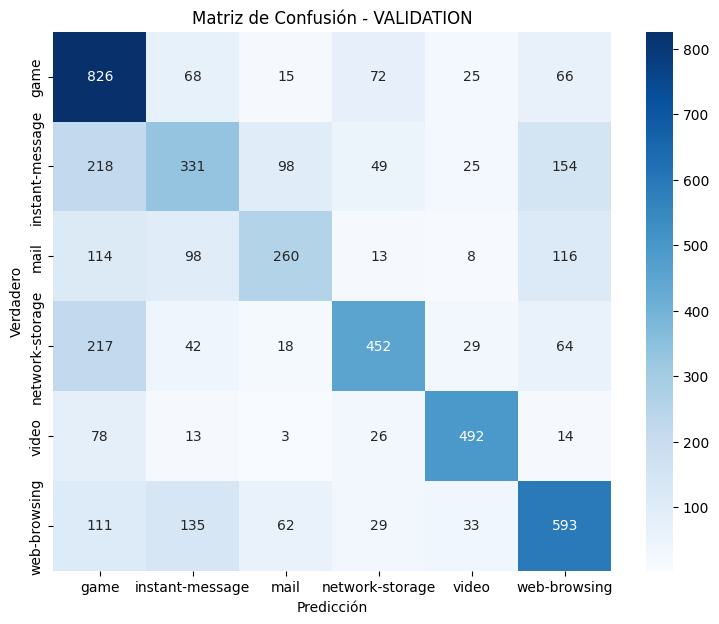

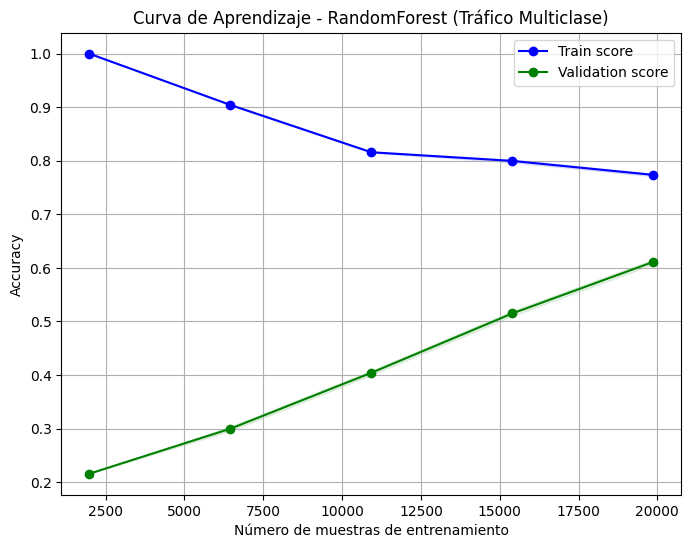


Scores finales en VALIDATION:
Accuracy: 0.595
F1-score (macro): 0.592
F1-score (weighted): 0.589
Accuracy promedio CV: 0.611 ± 0.005


In [5]:
# ==============================
# Evaluación en VALIDATION
# ==============================
best_clf = grid.best_estimator_
y_val_pred = best_clf.predict(X_val)

print("\n=== Reporte de clasificación en VALIDATION ===")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

# Matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - VALIDATION")
plt.show()

# ==============================
# Curva de aprendizaje
# ==============================
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    best_clf, X, y_encoded, cv=cv_outer, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.title("Curva de Aprendizaje - RandomForest (Tráfico Multiclase)")
plt.xlabel("Número de muestras de entrenamiento")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# ==============================
# Scores finales
# ==============================
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val_macro = f1_score(y_val, y_val_pred, average='macro')
f1_val_weighted = f1_score(y_val, y_val_pred, average='weighted')

print("\nScores finales en VALIDATION:")
print(f"Accuracy: {accuracy_val:.3f}")
print(f"F1-score (macro): {f1_val_macro:.3f}")
print(f"F1-score (weighted): {f1_val_weighted:.3f}")

# ==============================
# Validación cruzada completa
# ==============================
cv_scores = cross_val_score(best_clf, X, y_encoded, cv=cv_outer, scoring='accuracy')
print(f"Accuracy promedio CV: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

In [6]:
# Este script sigue las mismas caracteristicas del apartado anterior 
# la seleccion de dataset ahora se hace con features tipo ventana

# ==============================
# Cargar dataset
# ==============================
df = pd.read_csv('Dataset/dataset_all2.csv')  # Ajusta el path si es necesario
print(df.head())

   window_start    window_end  packets   bytes  duration  avg_pkt_size  \
0  1.693900e+09  1.693900e+09        1     144       1.0    144.000000   
1  1.693900e+09  1.693900e+09       18    5082       1.0    282.333333   
2  1.693900e+09  1.693900e+09      576  314467       1.0    545.949653   
3  1.693900e+09  1.693900e+09     1202  652591       1.0    542.920965   
4  1.693900e+09  1.693900e+09        2     140       1.0     70.000000   

   throughput  pkt_rate class  
0       144.0       1.0  game  
1      5082.0      18.0  game  
2    314467.0     576.0  game  
3    652591.0    1202.0  game  
4       140.0       2.0  game  


In [7]:
# ==============================
# Preparar features y etiquetas
# ==============================
X = df.drop(columns=['class'])
y = df['class']
# Codificar etiquetas

le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Clases codificadas:", le.classes_)


Clases codificadas: ['game' 'instant-message' 'mail' 'network-storage' 'video' 'web-browsing']


In [8]:
# ==============================
# División Train/Test/Validation
# ==============================
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)
# Aproximadamente 60% train, 20% test, 20% validation

# ==============================
# GridSearchCV para RandomForest
# ==============================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

clf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Mejores hiperparámetros encontrados: {grid.best_params_}")

# ==============================


Mejores hiperparámetros encontrados: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}



=== Reporte de clasificación en VALIDATION ===
                 precision    recall  f1-score   support

           game       1.00      0.99      0.99       231
instant-message       1.00      0.98      0.99        55
           mail       0.94      0.97      0.95        60
network-storage       0.98      1.00      0.99       177
          video       0.98      0.98      0.98       121
   web-browsing       0.97      0.96      0.96       119

       accuracy                           0.98       763
      macro avg       0.98      0.98      0.98       763
   weighted avg       0.98      0.98      0.98       763



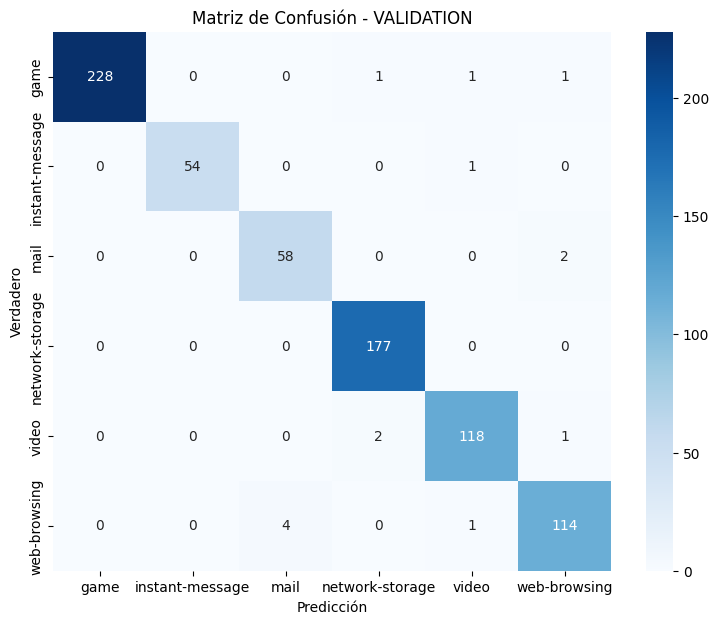

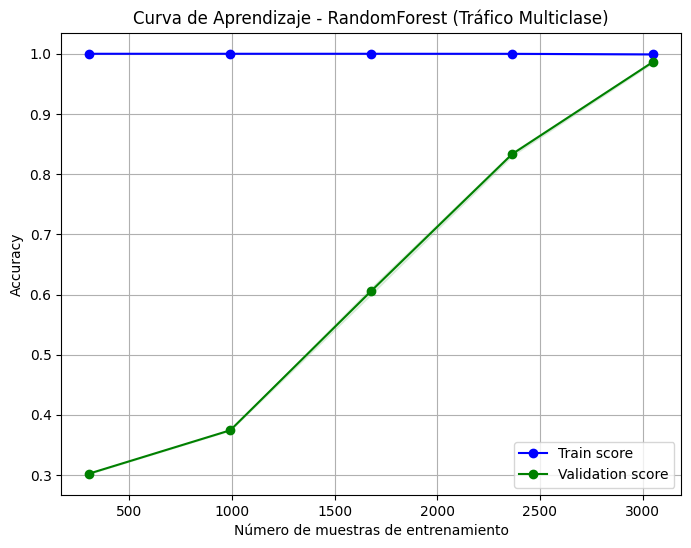


Scores finales en VALIDATION:
Accuracy: 0.982
F1-score (macro): 0.977
F1-score (weighted): 0.982
Accuracy promedio CV: 0.987 ± 0.002


In [9]:
# ==============================
# Evaluación en VALIDATION
# ==============================
best_clf = grid.best_estimator_
y_val_pred = best_clf.predict(X_val)

print("\n=== Reporte de clasificación en VALIDATION ===")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

# Matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - VALIDATION")
plt.show()

# ==============================
# Curva de aprendizaje
# ==============================
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    best_clf, X, y_encoded, cv=cv_outer, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.title("Curva de Aprendizaje - RandomForest (Tráfico Multiclase)")
plt.xlabel("Número de muestras de entrenamiento")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# ==============================
# Scores finales
# ==============================
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val_macro = f1_score(y_val, y_val_pred, average='macro')
f1_val_weighted = f1_score(y_val, y_val_pred, average='weighted')

print("\nScores finales en VALIDATION:")
print(f"Accuracy: {accuracy_val:.3f}")
print(f"F1-score (macro): {f1_val_macro:.3f}")
print(f"F1-score (weighted): {f1_val_weighted:.3f}")

# ==============================
# Validación cruzada completa
# ==============================
cv_scores = cross_val_score(best_clf, X, y_encoded, cv=cv_outer, scoring='accuracy')
print(f"Accuracy promedio CV: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")